In [1]:
!pip install blitz-bayesian-pytorch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 1.0 MB/s eta 0:00:00


In [2]:
import warnings
warnings.filterwarnings('ignore')


In [3]:
import matplotlib.pyplot as plt
import math
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import seaborn as sns
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from blitz.modules import BayesianLinear
from blitz.utils import variational_estimator
from torch.utils.data import TensorDataset, DataLoader
from matplotlib.pyplot import scatter, figure
from scipy import stats
from numpy.ma.core import outer
from sys import stderr


In [4]:
start = -7
end = 7
n = 300
batch_size = 16

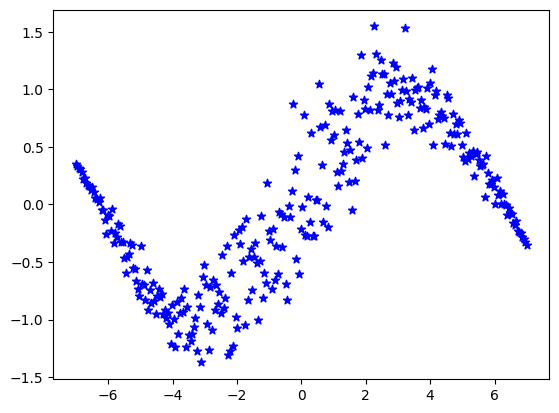

In [5]:
def sample_dataset(start, end, n):
    np.random.seed(0)
    x = np.linspace(start, end, n)
    sample_mean = [math.sin(i/2) for i in x]

    sample_var = [abs((abs(start)+abs(end))/2 - abs(i))/16 for i in x]
    y = stats.norm(sample_mean, sample_var).rvs(random_state=0)
    return x, y

x_train, y_train = sample_dataset(start, end, n)
scatter(x_train, y_train, c="blue", marker="*")

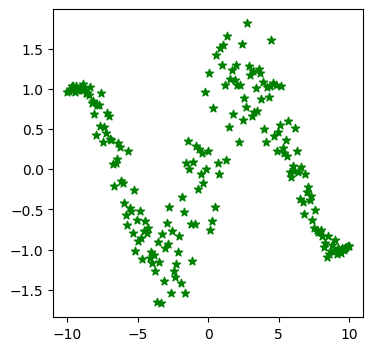

In [6]:
figure(figsize=(4, 4))
# Not exactely the same distribution, but works for now
x_test, y_test = sample_dataset(-10, 10, 200)
scatter(x_test, y_test, c="green", marker="*")

In [7]:

# Train
tensor_x = torch.Tensor(x_train).unsqueeze(1)
tensor_y = torch.Tensor(y_train).unsqueeze(1)
train_dataset = TensorDataset(tensor_x, tensor_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Test
tensor_x_test = torch.Tensor(x_test).unsqueeze(1)
tensor_y_test = torch.Tensor(y_test).unsqueeze(1)
test_dataset = TensorDataset(tensor_x_test, tensor_y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [8]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        hidden_size = 60

        self.fc1 = nn.Linear(1, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.mu = nn.Linear(hidden_size, 1)
        self.var = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h = torch.relu(self.fc1(x))
        h = torch.relu(self.fc2(h))
        mu = self.mu(h)
        var = torch.exp(self.var(h))
        return mu, var

model = SimpleNet()
print(model)
print("Params:", sum(p.numel() for p in model.parameters() if p.requires_grad))

SimpleNet(
  (fc1): Linear(in_features=1, out_features=60, bias=True)
  (fc2): Linear(in_features=60, out_features=60, bias=True)
  (mu): Linear(in_features=60, out_features=1, bias=True)
  (var): Linear(in_features=60, out_features=1, bias=True)
)
Params: 3902


In [9]:
def make_plot_de(model):
    mus = []
    vars = []
    for m in model:
        mu, var = m(tensor_x_test)
        mus.append(mu)
        vars.append(var)

    # For epistemic uncertainty we calculate the std on the mus!
    # Arash: note how vars is no longer used in evaluation
    means = torch.stack(mus).mean(axis=0).detach().numpy()
    stds = torch.stack(mus).std(axis=0).detach().numpy()**(1/2)

    dfs = []
    y_vals = [means, means+2*stds, means-2*stds]

    for i in range(3):
      data = {
            "x": list(tensor_x_test.squeeze().numpy()),
            "y": list(y_vals[i].squeeze())
      }
      temp = pd.DataFrame.from_dict(data)
      dfs.append(temp)

    df = pd.concat(dfs).reset_index()

    # Plot predictions with confidence
    sns_plot = sns.lineplot(data=df, x="x", y="y")

    # Highligh training range
    plt.axvline(x=start)
    plt.axvline(x=end)

    # Plot train data on top
    scatter(x_train, y_train, c="green", marker="*", alpha=0.1)

    plt.show()

In [11]:
# Construct ensemble
num_models = 5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
deep_ensemble = [SimpleNet().to(device) for i in range(num_models)]
criterion = torch.nn.GaussianNLLLoss(eps=1e-02)
optimizers = [optim.Adam(m.parameters(), lr=0.001) for m in deep_ensemble]

In [19]:
def denn():
  # Construct ensemble
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  num_models = 5
  deep_ensemble = [SimpleNet().to(device) for i in range(num_models)]
  criterion = torch.nn.GaussianNLLLoss(eps=1e-02)
  optimizers = [optim.Adam(m.parameters(), lr=0.001) for m in deep_ensemble]
  for epoch in range(150):
    # Train loop
    for batch in train_loader:
        x = batch[0].to(device)
        y = batch[1].to(device)

        losses = []
        mus = []
        vars = []
        for i, model in enumerate(deep_ensemble):
            optimizers[i].zero_grad()
            mu, var = model(x)
            loss = criterion(mu, y, var)
            loss.backward()
            optimizers[i].step()
            criterionmse_train = nn.MSELoss()
            mse_train = criterionmse_train(mu, y)
            losses.append(loss.item())
            mus.append(mu)
            vars.append(var)
        loss = sum(losses)/len(losses)

    if epoch % 10 == 0:
        all_test_losses = []
        all_mse_test=[]
        # Test loop
        for batch in test_loader:
            x = batch[0].to(device)
            y = batch[1].to(device)

            test_losses = []
            mus = []
            vars = []
            for i, model in enumerate(deep_ensemble):
                optimizers[i].zero_grad()
                mu, var = model(x)
                test_loss = criterion(mu, y, var)
                optimizers[i].step()

                test_losses.append(test_loss.item())
                mus.append(mu)
                vars.append(var)
            all_test_losses.append((sum(test_losses)/len(test_losses)))
            criterionmse_test = nn.MSELoss()
            all_mse_test.append(criterionmse_test(mu,y).item())
  test_loss = sum(all_test_losses)/len(all_test_losses)
  test_mse=sum(all_mse_test)/len(all_mse_test)
  print(f"Epoch {epoch} | batch train loss: {loss} | test loss: {test_loss}")
  print(f"Epoch {epoch} |batch train mse:{mse_train}| test mse:{test_mse}")
  make_plot_de(deep_ensemble)
  return loss,test_loss,mse_train, test_mse


Epoch 149 | batch train loss: -1.2960106134414673 | test loss: 0.8324000497276967
Epoch 149 |batch train mse:0.03480204939842224| test mse:0.15555405674072412


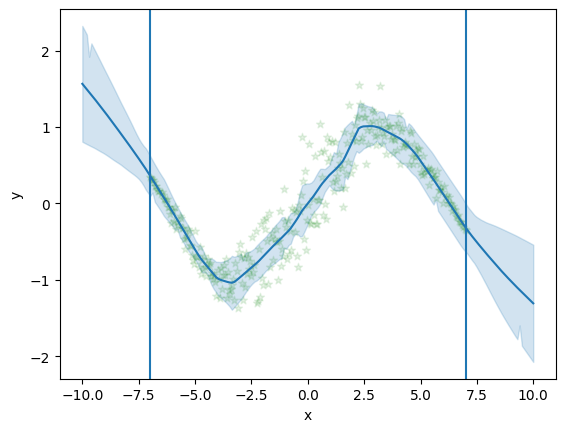

Epoch 149 | batch train loss: -0.973699951171875 | test loss: 0.6655703922876945
Epoch 149 |batch train mse:0.03375309705734253| test mse:0.14251963880199653


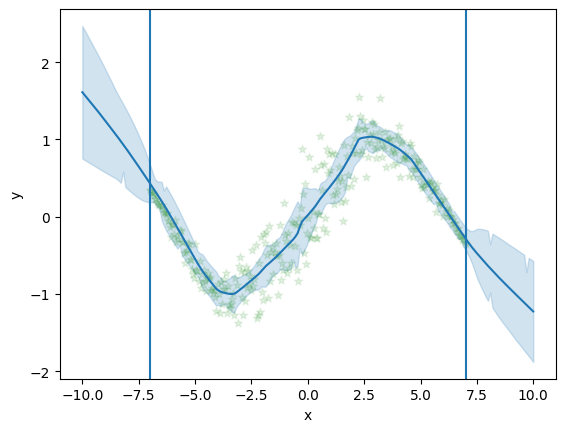

Epoch 149 | batch train loss: -1.4054797887802124 | test loss: 0.9202979192137719
Epoch 149 |batch train mse:0.02065497636795044| test mse:0.14999455786668336


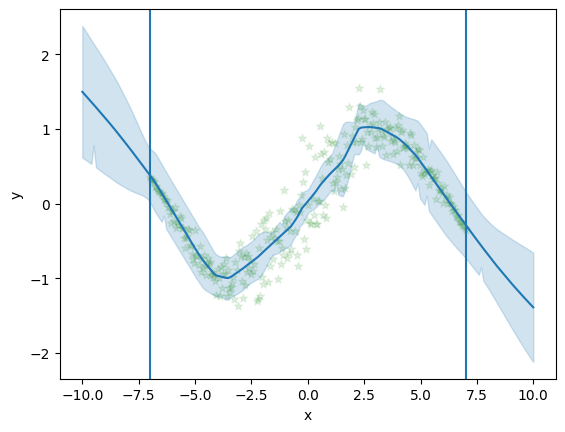

Epoch 149 | batch train loss: -0.9931171298027038 | test loss: 0.4117773848084303
Epoch 149 |batch train mse:0.06136023625731468| test mse:0.14496848502984414


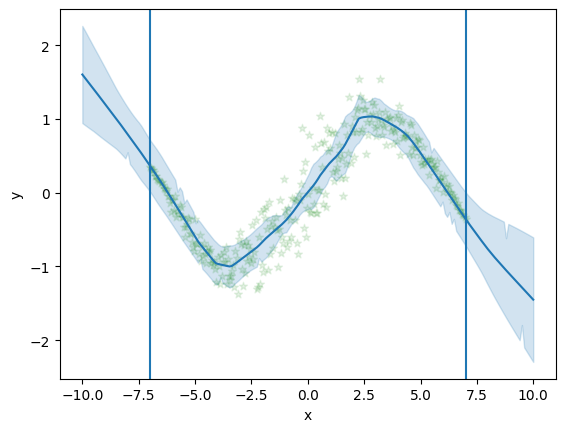

Epoch 149 | batch train loss: -1.457370138168335 | test loss: 0.2545691946378121
Epoch 149 |batch train mse:0.03085029311478138| test mse:0.14248704623717529


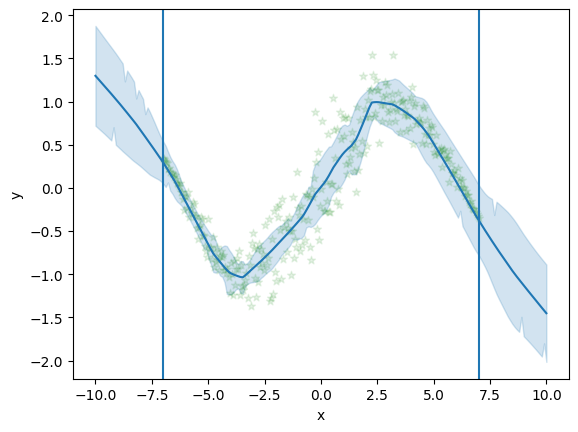

Epoch 149 | batch train loss: -1.1327381134033203 | test loss: 0.22464468123821113
Epoch 149 |batch train mse:0.04087822884321213| test mse:0.14719091814297897


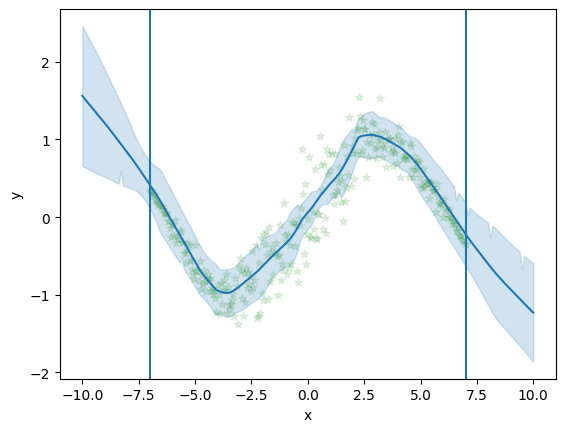

Epoch 149 | batch train loss: -1.289253568649292 | test loss: 0.7287933165064225
Epoch 149 |batch train mse:0.05659891292452812| test mse:0.15768042779885805


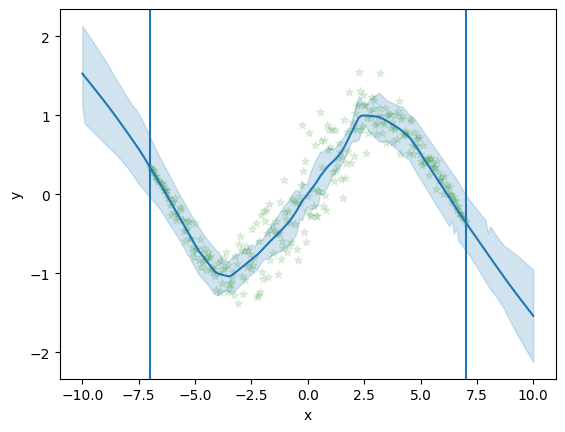

Epoch 149 | batch train loss: -1.1391735315322875 | test loss: 0.5134396363909428
Epoch 149 |batch train mse:0.08598276972770691| test mse:0.15502021089196205


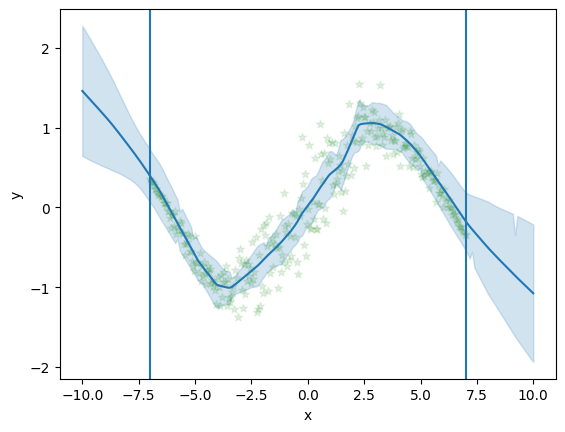

Epoch 149 | batch train loss: -1.122885537147522 | test loss: 0.45485750803580655
Epoch 149 |batch train mse:0.028407828882336617| test mse:0.1487949533531299


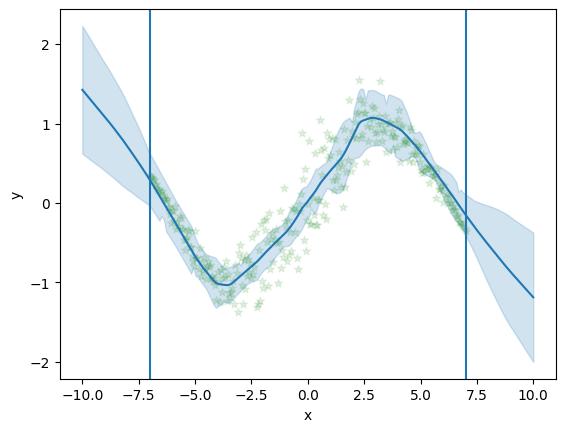

Epoch 149 | batch train loss: -1.3126938104629517 | test loss: 0.7712975770808185
Epoch 149 |batch train mse:0.030853675678372383| test mse:0.16172771557019308


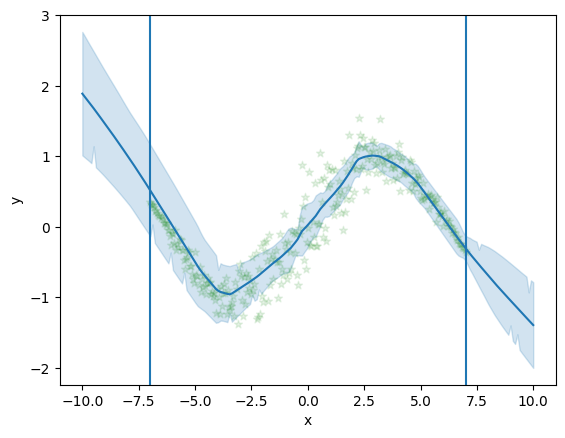

In [21]:
train_losses=[]
test_losses=[]
errors_train=[]
errors_test=[]
for i in range(10):
  tr_loss,test_loss,mse_tr,mse_test = denn()
  train_losses.append(tr_loss)
  test_losses.append(test_loss)
  errors_train.append(mse_tr)
  errors_test.append(mse_test)


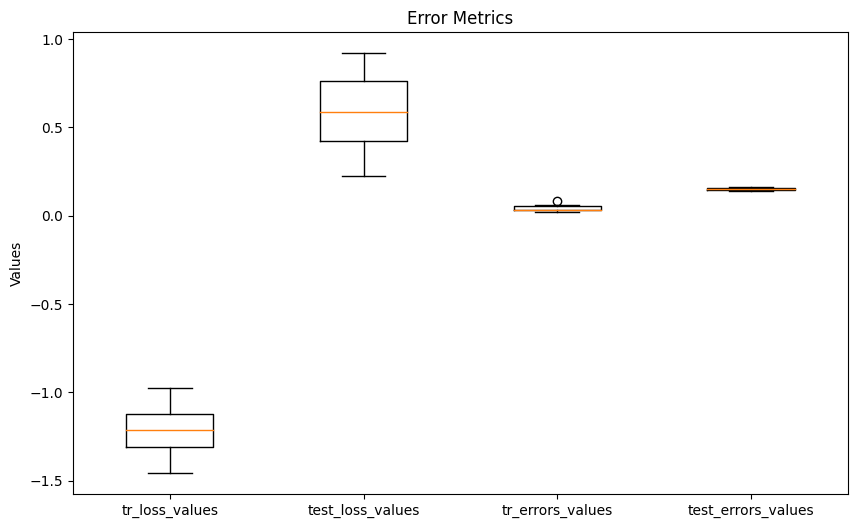

In [25]:
# Extract numerical values from the tensors and remove grad_fn
tr_loss_values= train_losses
test_loss_values=test_losses
tr_errors_values=  [tensor.item() for tensor in errors_train]
test_errors_values= errors_test

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create box plots for each dataset
box_plot_data = [tr_loss_values, test_loss_values, tr_errors_values, test_errors_values]
box_labels = ['tr_loss_values', 'test_loss_values', 'tr_errors_values', 'test_errors_values']

ax.boxplot(box_plot_data, labels=box_labels)

# Add labels and title

ax.set_ylabel('Values')
ax.set_title('Error Metrics')

# Show the plot
plt.show()



In [26]:
# Create a DataFrame from the lists
data = {
    'Training Loss': tr_loss_values,
    'Testing Loss': test_loss_values,
    'Mean Squared Training Error': tr_errors_values,
    'Mean Squared Testing Error': test_errors_values
}

num_columns = len(data)

column_names = ['Training Loss','Testing Loss', 'Mean Squared Training Error','Mean Squared Testing Error']

# Create a DataFrame with dynamic column names
df = pd.DataFrame(data, columns=column_names)
df.index += 1
# Display the DataFrame as a table
print(df)

    Training Loss  Testing Loss  Mean Squared Training Error  \
1       -1.296011      0.832400                     0.034802   
2       -0.973700      0.665570                     0.033753   
3       -1.405480      0.920298                     0.020655   
4       -0.993117      0.411777                     0.061360   
5       -1.457370      0.254569                     0.030850   
6       -1.132738      0.224645                     0.040878   
7       -1.289254      0.728793                     0.056599   
8       -1.139174      0.513440                     0.085983   
9       -1.122886      0.454858                     0.028408   
10      -1.312694      0.771298                     0.030854   

    Mean Squared Testing Error  
1                     0.155554  
2                     0.142520  
3                     0.149995  
4                     0.144968  
5                     0.142487  
6                     0.147191  
7                     0.157680  
8                     0.155020 